<a href="https://colab.research.google.com/github/ancestor9/Affalatoxin-Analysis/blob/main/DL_prediction/20251010_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/FDA/data/merged_df.pkl'
df = pd.read_pickle(path, compression='gzip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Target mean

df = df.drop(columns=['사용주소', 'PRDLST_NM', 'JDGMNT_WORD_NAME'])
## traget mean ###
df['교차_조합'] = df['1차 식품 분류 (세부)'] + '_' + df['INSPCT_PURPS_NAME']
cross_mean = df.groupby('교차_조합')['JDGMNT_WORD_NAME_encoded'].mean()
df['Target_Mean'] = df['교차_조합'].map(cross_mean)
# print("\n--- 실제 계산된 교차 조합별 Target Mean 값 ---")
# print(cross_mean)
df.drop(columns=['교차_조합'], inplace=True)

In [12]:
X_ts = df.iloc[:, : -6]
print(f'시게열변수 개수 {540/60}')
X_lm = df[['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']]

시게열변수 개수 9.0


In [13]:
y = df['JDGMNT_WORD_NAME_encoded']
y.value_counts(normalize=True)

,proportion
JDGMNT_WORD_NAME_encoded,
0,0.988279
1,0.011721


In [26]:
df.loc[:, 'tmprt_150_59':]

,tmprt_150_59,INSPCT_PURPS_NAME,1차 식품 분류 (세부),결과,결과값,JDGMNT_WORD_NAME_encoded,Target_Mean
0,12.1,자가품질위탁검사,"과자류, 빵류 또는 떡류",불검출,0,0,0.007676
1,12.1,자가품질위탁검사,"과자류, 빵류 또는 떡류",불검출,0,0,0.007676
2,12.7,자가품질위탁검사,"과자류, 빵류 또는 떡류",불검출,0,0,0.007676
3,12.5,자가품질위탁검사,건강기능식품(제품),불검출,0,0,0.003497
4,12.5,자가품질위탁검사,건강기능식품(제품),불검출,0,0,0.003497
...,...,...,...,...,...,...,...
337243,0.0,압·몰수품검사,기타식품류,불검출,0,0,0.087719
337244,0.0,압·몰수품검사,기타식품류,불검출,0,0,0.087719
337245,0.0,압·몰수품검사,기타식품류,불검출,0,0,0.087719
337246,15.7,압·몰수품검사,기타식품류,불검출,0,0,0.087719


### 입력변수는 아래와 같이 2개의 데이터로 구성됨
- 60일 동안의 일평균기온, 일평균 습도, 일평균 일조량 으로 구성된 총 180개 컬럼과 5년 동안 daily 데이터 365*3 의 시계열데이터 (337248, 546) 크기의 시계열데이터(X_ts)
- 식품종류, 검사종류, target mean(float)으로 구성된 데이터(337249, 3) 크기의 일반데이터(X_lm)

### targe(y)는 적합과 부적합 0,1로 구성되었으며 부적합(1)이 1.1%이다.

### 데이터전처리
- 시계열데이터는 표준화하여 3D tensor로 feature 9개 timestamp 60개로 구성하고
- 식품종류, 검사종류느 onehotcode 전처리를 한 후
- SMOTE 를 적용하여

### Hybrid 딥러닝을 구성하여 예측하려고 한다.
- 시계열데이터는 LSTM + Attention 모델을 적용
- 일반데이터는 FNN을 구성하여
- concate 하여 예측

                ┌────────────────────────────┐
                │      시계열 입력 (X_ts)     │
                │ shape = (batch, 60, 9)     │
                └──────────────┬─────────────┘
                               │
                      ┌────────▼─────────┐
                      │     LSTM Layer    │
                      │   (64 units)      │
                      └────────┬──────────┘
                               │
                      ┌────────▼─────────┐
                      │   Attention Layer │
                      └────────┬──────────┘
                               │
                   ┌───────────▼───────────┐
                   │ Dense + BatchNorm +   │
                   │ Dropout (time branch) │
                   └───────────┬───────────┘
                               │
                ┌──────────────▼──────────────┐
                │     일반 입력 (X_lm)         │
                │ one-hot encoded categorical  │
                └──────────────┬──────────────┘
                               │
                ┌──────────────▼──────────────┐
                │  FeedForward Network (FNN)  │
                │ Dense + BatchNorm + Dropout │
                └──────────────┬──────────────┘
                               │
               ┌───────────────▼────────────────┐
               │     Concatenate (병합)         │
               └───────────────┬────────────────┘
                               │
                     ┌─────────▼─────────┐
                     │  Dense(64) + BN   │
                     │  Dropout(0.5)     │
                     └─────────┬─────────┘
                               │
                     ┌─────────▼─────────┐
                     │ Dense(1, sigmoid) │
                     └─────────┬─────────┘
                               │
                      ┌────────▼─────────┐
                      │  Output: y_pred  │
                      │ (0=적합, 1=부적합) │
                      └──────────────────┘


| 구성 요소                   | 설명                                   |
| ----------------------- | ------------------------------------ |
| **LSTM + Attention**    | 시계열 패턴(온도, 습도, 일조량 등)의 시퀀스 의존성 학습    |
| **Batch Normalization** | 각 층의 활성값 분포를 정규화하여 과적합 방지            |
| **Dropout (0.3~0.5)**   | 랜덤하게 뉴런을 비활성화하여 일반화 성능 향상            |
| **FNN (Feedforward)**   | 범주형 정보(식품종류, 검사종류) 처리                |
| **Concatenate Layer**   | 시계열 + 일반 데이터 결합                      |
| **Output Layer**        | Sigmoid(이진 분류), Positive(부적합) 예측을 중점 |


| 구분          | 데이터    | shape          | 설명                                                    |
| ----------- | ------ | -------------- | ----------------------------------------------------- |
| **시계열 데이터** | `X_ts` | (337,248, 540) | 9개 feature × 60일 → 540개의 column                       |
| **일반 데이터**  | `X_lm` | (337,248, 3)   | ['INSPECT_PURPS_NAME', '1차 식품 분류(세부)', 'Target_Mean'] |
| **타깃**      | `y`    | (337,248, 1)   | ['JDGMENT_WORD_NAME_encoded'] (0: 적합, 1: 부적합, 1.17%)  |


In [14]:
!pip install imblearn -q

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Layer

# ---------------------------
# 1️⃣ 시계열 데이터 변환
# ---------------------------
# X_ts: (337248, 540)
n_features = 9
timesteps = 60
# Convert DataFrame to NumPy array before reshaping
X_ts = X_ts.values.reshape(-1, timesteps, n_features)

# 표준화 (each feature 기준)
scaler = StandardScaler()
X_ts_2d = X_ts.reshape(-1, n_features)
X_ts_scaled = scaler.fit_transform(X_ts_2d).reshape(-1, timesteps, n_features)

# ---------------------------
# 2️⃣ 일반 데이터 전처리
# ---------------------------
cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
num_cols = ['Target_Mean']

encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(X_lm[cat_cols])
X_num = X_lm[num_cols].values

X_lm_proc = np.hstack([X_cat, X_num])

# ---------------------------
# 3️⃣ 데이터 분리
# ---------------------------
X_ts_train, X_ts_test, X_lm_train, X_lm_test, y_train, y_test = train_test_split(
    X_ts_scaled, X_lm_proc, y, test_size=0.2, stratify=y, random_state=42
)

## attension 알고리즘 사용 이유
- 정보 중요도 학습 (Learning Feature Importance over Time): 일반적인 LSTM은 시퀀스의 모든 정보를 균등하게 처리하거나, 마지막 히든 상태에 모든 정보를 압축하려 합니다. 하지만 Attention 메커니즘은 시퀀스 내의 각 시점(time step)이 최종 출력에 미치는 영향의 중요도를 학습하여, 모델이 예측에 더 중요한 영향을 미치는 부분에 "주의(attention)"를 기울이도록 합니다. 이는 특히 긴 시계열 데이터에서 특정 이벤트나 시점이 중요한 경우에 유용합니다.
- 해석 가능성 향상 (Improved Interpretability): Attention 가중치를 분석하면 모델이 어떤 시점의 정보에 집중했는지 알 수 있어, 모델의 결정을 더 잘 이해할 수 있습니다. 예를 들어, 특정 지표의 급격한 변화 시점에 Attention 가중치가 높다면, 모델이 그 변화를 중요한 신호로 인식했다는 것을 파악할 수 있습니다.
- 장기 의존성 문제 완화 (Mitigating Long-term Dependency Issues): LSTM 자체로도 장기 의존성 문제를 어느 정도 다루지만, 매우 긴 시퀀스의 경우 여전히 정보 손실의 위험이 있습니다. Attention 메커니즘은 멀리 떨어진 과거 시점의 정보라도 중요하다고 판단되면 직접적으로 참조할 수 있게 하여, 장기 의존성 문제를 완화하고 성능을 향상시킬 수 있습니다.
- 정보 압축의 효율성 (Efficient Information Summarization): Attention Layer는 LSTM의 모든 시점 출력을 단순히 concatenate 하는 대신, 학습된 가중치에 따라 관련 있는 정보만을 효과적으로 압축하여 고정된 크기의 벡터로 만듭니다. 이 압축된 벡터는 일반 데이터 브랜치와 결합되어 최종 예측에 사용됩니다.

In [ ]:

# ---------------------------
# 4️⃣ SMOTE (정형데이터 기반)
# ---------------------------
# Flatten X_ts_train for SMOTE
X_ts_train_flat = X_ts_train.reshape(X_ts_train.shape[0], -1)

# Concatenate flattened X_ts_train and X_lm_train for SMOTE input
X_train_combined = np.concatenate([X_ts_train_flat, X_lm_train], axis=1)

sm = SMOTE(random_state=42)
X_resampled, y_train_res = sm.fit_resample(X_train_combined, y_train)

# Split the resampled data back into time-series and tabular parts
ts_flat_shape = X_ts_train_flat.shape[1]
X_ts_train_res_flat = X_resampled[:, :ts_flat_shape]
X_lm_train_res = X_resampled[:, ts_flat_shape:]

# Reshape the time-series data back to 3D
X_ts_train_res = X_ts_train_res_flat.reshape(-1, timesteps, n_features)


# ---------------------------
# 5️⃣ Attention Layer 정의
# ---------------------------
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output

# ---------------------------
# 6️⃣ Hybrid 모델 정의
# ---------------------------
# Time-series branch
input_ts = Input(shape=(timesteps, n_features))
x_ts = layers.LSTM(64, return_sequences=True)(input_ts)
x_ts = AttentionLayer()(x_ts)
x_ts = layers.BatchNormalization()(x_ts)
x_ts = layers.Dropout(0.4)(x_ts)
x_ts = layers.Dense(64, activation='relu')(x_ts)

# Lab-data branch
input_lm = Input(shape=(X_lm_proc.shape[1],))
x_lm = layers.Dense(64, activation='relu')(input_lm)
x_lm = layers.BatchNormalization()(x_lm)
x_lm = layers.Dropout(0.3)(x_lm)
x_lm = layers.Dense(32, activation='relu')(x_lm)

# Merge
x = layers.Concatenate()([x_ts, x_lm])
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[input_ts, input_lm], outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name="precision")]
)

# ---------------------------
# 7️⃣ 모델 학습
# ---------------------------
early_stop = EarlyStopping(monitor='val_recall', mode='max', patience=10, restore_best_weights=True)

history = model.fit(
    [X_ts_train_res, X_lm_train_res],
    y_train_res,
    validation_data=([X_ts_test, X_lm_test], y_test),
    epochs=50,
    batch_size=256,
    callbacks=[early_stop]
)

# ---------------------------
# 8️⃣ 예측 및 평가
# ---------------------------
y_pred_prob = model.predict([X_ts_test, X_lm_test])
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ---------------------------
# 9️⃣ 임계값 변화에 따른 Recall, Precision, F1, Q-Rate
# ---------------------------
thresholds = np.linspace(0.1, 0.9, 9)
recalls, precisions, f1s, q_rates = [], [], [], []

for t in thresholds:
    y_pred_t = (y_pred_prob > t).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred_t, average='binary', zero_division=0)
    q_rate = (y_pred_t == 1).mean()
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)
    q_rates.append(q_rate)

plt.figure(figsize=(7,5))
plt.plot(thresholds, recalls, 'o-', label='Recall')
plt.plot(thresholds, precisions, 'o-', label='Precision')
plt.plot(thresholds, f1s, 'o-', label='F1-score')
plt.plot(thresholds, q_rates, 'o-', label='Q-rate')
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Threshold vs Metrics")
plt.legend()
plt.grid(True)
plt.show()

## 2. 개선 코드
✅ 주요 개선점 요약
목표	반영 내용
- Goal 1: Overfitting 방지	모든 Dense/LSTM 층에 BatchNormalization, Dropout(0.4) 추가. EarlyStopping과 ReduceLROnPlateau 콜백 포함
- Goal 2: Positive 탐지 중심	Binary Crossentropy 대신 Focal Loss(α=0.75, γ=2) 적용. Recall/Precision/AUC 메트릭 모니터링
- Goal 3: 시각화	confusion_matrix를 seaborn heatmap으로 시각화, classification report 출력
- Goal 4: Threshold 분석	0.1~0.9 임계값별 recall, precision, f1-score, q-rate(positive rate) 곡선을 모두 플롯
⚙️ 실무 팁

Positive 탐지 강화: Recall이 최우선이라면 threshold를 0.3~0.4로 조정하거나 alpha↑, gamma↓ 조정으로 Focal Loss 감도 높이기.

Validation 셋 유지: SMOTE는 Train 셋에만 적용하고, Validation은 원본 분포 유지하는 것이 이상적.

Metrics 모니터링: val_recall 또는 val_auc를 EarlyStopping 기준으로 설정.

Explainability: 추후 SHAP을 병합해 tabular branch feature importance를 시각화할 수도 있다.

4가지 목표(overfitting 방지, Positive 탐지 최적화, classification 시각화, 임계값(Threshold) 분석)을 모두 반영한 완전한 Hybrid 모델 학습 파이프라인 코드이다.

이 코드는 이전 버전을 확장하여,

BatchNormalization + Dropout + EarlyStopping 등을 체계적으로 추가하고,

Positive(1, 부적합) 탐지를 최대화하도록 Focal Loss 기반 Objective로 수정하며,

classification report, confusion matrix를 시각화로 출력하고,

threshold별 recall, precision, F1-score, q-rate(정확히는 positive 판정률) 커브를 함께 그린다

Training data shapes:
  X_ts_train: (533272, 60, 9)
  X_tab_train: (533272, 51)
  y_train: (533272,)

Validation data shapes:
  X_ts_val: (67450, 60, 9)
  X_tab_val: (67450, 51)
  y_val: (67450,)
Epoch 1/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.6414 - auc: 0.7266 - loss: 0.0842 - precision: 0.5981 - recall: 0.8554 - val_accuracy: 0.6442 - val_auc: 0.6876 - val_loss: 0.0432 - val_precision: 0.0201 - val_recall: 0.6144 - learning_rate: 0.0010
Epoch 2/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.8163 - auc: 0.9357 - loss: 0.0352 - precision: 0.7512 - recall: 0.9479 - val_accuracy: 0.6880 - val_auc: 0.7140 - val_loss: 0.0451 - val_precision: 0.0221 - val_recall: 0.5917 - learning_rate: 0.0010
Epoch 3/50
2084/2084 ━━━━━━━━━━━━━━━━━━━━ 49s 23ms/step - accuracy: 0.8743 - auc: 0.9664 - loss: 0.0259 - precision: 0.8191 - recall: 0.9605 - val_accuracy: 0.7397 - val_auc: 0.7351 - val_loss: 0.0371 - val_precision: 0.0253 - val_recall: 0.5651 - learning_rate: 0

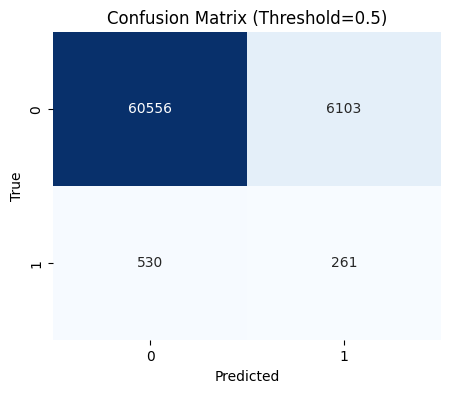

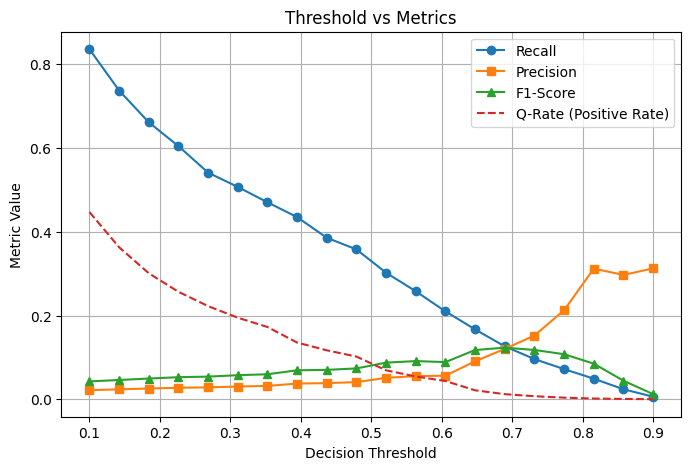

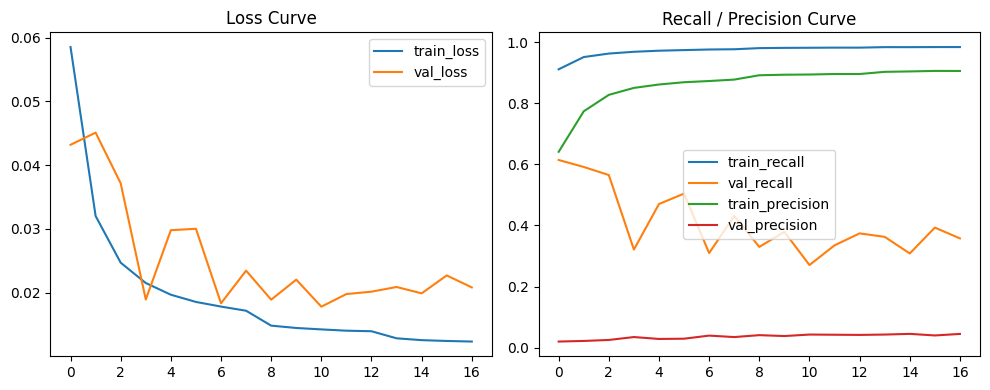

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Layer
import matplotlib.pyplot as plt
import seaborn as sns


# ===============================
#  Attention Layer
# ===============================
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(name='att_u',
                                 shape=(input_shape[-1],),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu, axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output


# ===============================
#  Focal Loss for Imbalance
# ===============================
def focal_loss(alpha=0.75, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = 1e-8
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        loss_pos = -alpha * tf.pow(1 - y_pred, gamma) * tf.math.log(y_pred)
        loss_neg = -(1 - alpha) * tf.pow(y_pred, gamma) * tf.math.log(1 - y_pred)
        loss = tf.where(tf.equal(y_true, 1), loss_pos, loss_neg)
        return tf.reduce_mean(loss)
    return focal_loss_fixed


# ===============================
#  Data preprocessing (첫번째 코드 데이터 구조에 맞게 수정)
# ===============================
def preprocess(X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42):
    """
    X_ts: (337248, 540) - 시계열 데이터
    X_lm: DataFrame with ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']
    y: 타겟 변수
    """
    # 1️⃣ 시계열 데이터 reshape
    X_ts = X_ts.reshape(-1, timesteps, n_features)

    # 2️⃣ 시계열 표준화
    scaler = StandardScaler()
    X_ts_2d = X_ts.reshape(-1, n_features)
    X_ts_scaled = scaler.fit_transform(X_ts_2d).reshape(-1, timesteps, n_features)

    # 3️⃣ 일반 데이터 전처리
    cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
    num_cols = ['Target_Mean']

    encoder = OneHotEncoder(sparse_output=False)
    X_cat = encoder.fit_transform(X_lm[cat_cols])
    X_num = X_lm[num_cols].values

    X_lm_proc = np.hstack([X_cat, X_num])

    # 4️⃣ 데이터 분리
    X_ts_train, X_ts_test, X_lm_train, X_lm_test, y_train, y_test = train_test_split(
        X_ts_scaled, X_lm_proc, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # 5️⃣ SMOTE 적용
    X_ts_train_flat = X_ts_train.reshape(X_ts_train.shape[0], -1)
    X_train_combined = np.concatenate([X_ts_train_flat, X_lm_train], axis=1)

    sm = SMOTE(random_state=random_state)
    X_resampled, y_train_res = sm.fit_resample(X_train_combined, y_train)

    # 6️⃣ 분리 및 reshape
    ts_flat_shape = X_ts_train_flat.shape[1]
    X_ts_train_res_flat = X_resampled[:, :ts_flat_shape]
    X_lm_train_res = X_resampled[:, ts_flat_shape:]

    X_ts_train_res = X_ts_train_res_flat.reshape(-1, timesteps, n_features)

    return X_ts_train_res, X_lm_train_res, y_train_res, X_ts_test, X_lm_test, y_test


# ===============================
#  Hybrid Model (LSTM + Attention + FNN)
# ===============================
def build_hybrid_model(n_timestamps, n_features_ts, n_tab_features,
                       lstm_units=64, fnn_units=[64, 32],
                       dropout=0.4, learning_rate=1e-3):

    # 시계열 branch
    ts_input = layers.Input(shape=(n_timestamps, n_features_ts), name='ts_input')
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(ts_input)
    x = layers.BatchNormalization()(x)
    x = layers.Bidirectional(layers.LSTM(lstm_units // 2, return_sequences=True))(x)
    x = layers.BatchNormalization()(x)
    att_out = AttentionLayer()(x)
    att_out = layers.Dropout(dropout)(att_out)

    # 일반 데이터 branch
    tab_input = layers.Input(shape=(n_tab_features,), name='tab_input')
    t = layers.Dense(fnn_units[0], activation='relu')(tab_input)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)
    t = layers.Dense(fnn_units[1], activation='relu')(t)
    t = layers.BatchNormalization()(t)
    t = layers.Dropout(dropout)(t)

    # 결합
    merged = layers.Concatenate()([att_out, t])
    m = layers.Dense(64, activation='relu')(merged)
    m = layers.BatchNormalization()(m)
    m = layers.Dropout(dropout)(m)
    output = layers.Dense(1, activation='sigmoid')(m)

    model = models.Model(inputs=[ts_input, tab_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate),
                  loss=focal_loss(alpha=0.75, gamma=2),
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall'),
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.AUC(name='auc')])
    return model


# ===============================
#  Training & Evaluation
# ===============================
def train_and_evaluate(X_ts_train, X_tab_train, y_train,
                       X_ts_val, X_tab_val, y_val,
                       epochs=50, batch_size=256):

    model = build_hybrid_model(n_timestamps=X_ts_train.shape[1],
                               n_features_ts=X_ts_train.shape[2],
                               n_tab_features=X_tab_train.shape[1])

    es = callbacks.EarlyStopping(monitor='val_auc', patience=8, mode='max',
                                 restore_best_weights=True)
    rl = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=4,
                                     mode='max', min_lr=1e-6, verbose=1)

    history = model.fit(
        {'ts_input': X_ts_train, 'tab_input': X_tab_train}, y_train,
        validation_data=({'ts_input': X_ts_val, 'tab_input': X_tab_val}, y_val),
        epochs=epochs, batch_size=batch_size, callbacks=[es, rl], verbose=1
    )

    # 예측
    y_prob = model.predict({'ts_input': X_ts_val, 'tab_input': X_tab_val}).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # ========== Classification Report ==========
    print("\n[Classification Report]")
    print(classification_report(y_val, y_pred, digits=4))
    print("ROC-AUC:", roc_auc_score(y_val, y_prob))

    # ========== Confusion Matrix 시각화 ==========
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix (Threshold=0.5)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ========== Threshold 분석 ==========
    thresholds = np.linspace(0.1, 0.9, 20)
    recalls, precisions, f1s, q_rates = [], [], [], []

    for th in thresholds:
        pred = (y_prob >= th).astype(int)
        recalls.append(recall_score(y_val, pred, zero_division=0))
        precisions.append(precision_score(y_val, pred, zero_division=0))
        f1s.append(f1_score(y_val, pred, zero_division=0))
        q_rates.append(np.mean(pred))

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, recalls, label='Recall', marker='o')
    plt.plot(thresholds, precisions, label='Precision', marker='s')
    plt.plot(thresholds, f1s, label='F1-Score', marker='^')
    plt.plot(thresholds, q_rates, label='Q-Rate (Positive Rate)', linestyle='--')
    plt.xlabel('Decision Threshold')
    plt.ylabel('Metric Value')
    plt.title('Threshold vs Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 학습 곡선 시각화
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='train_recall')
    plt.plot(history.history['val_recall'], label='val_recall')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title('Recall / Precision Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model


# ===============================
#  Main Execution
# ===============================
if __name__ == "__main__":
    # 첫 번째 코드에서 가져온 데이터 사용
    # X_ts: (337248, 540)
    # X_lm: DataFrame with ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']
    # y: 타겟 변수

    # 전처리 수행
    X_ts_train, X_tab_train, y_train, X_ts_val, X_tab_val, y_val = preprocess(
        X_ts, X_lm, y, n_features=9, timesteps=60, random_state=42
    )

    print(f"Training data shapes:")
    print(f"  X_ts_train: {X_ts_train.shape}")
    print(f"  X_tab_train: {X_tab_train.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"\nValidation data shapes:")
    print(f"  X_ts_val: {X_ts_val.shape}")
    print(f"  X_tab_val: {X_tab_val.shape}")
    print(f"  y_val: {y_val.shape}")

    # 모델 학습 및 평가
    model = train_and_evaluate(
        X_ts_train, X_tab_train, y_train,
        X_ts_val, X_tab_val, y_val,
        epochs=50, batch_size=256
    )

## 3. SMOTE(Data Leakage 방지) 규칙을 준수하도록 전체 학습 파이프라인을 안전하게 수정

✅ 주요 개선점 요약
SMOTE(Data Leakage 방지) 규칙을 준수하도록 전체 학습 파이프라인을 안전하게 수정하겠습니다.

핵심 원칙은 다음과 같습니다:

train_test_split → SMOTE 순서로 진행

SMOTE는 train 데이터에만 적용

test 데이터는 절대 오버샘플링하지 않음

아래는 이 원칙을 반영한 수정된 코드입니다.


| 구분                     | 기존 문제                              | 수정 방향                                    |
| ---------------------- | ---------------------------------- | ---------------------------------------- |
| **SMOTE 적용 위치**        | 전체 데이터에 SMOTE 적용 → Data Leakage 발생 | `train_test_split` 후 **train만 SMOTE 적용** |
| **Encoding & Scaling** | 전체 데이터 fit → test 정보 누출            | train에만 `fit`, test에는 `transform`        |
| **EarlyStopping 기준**   | loss 기준                            | **Recall 기준**으로 전환 (Positive 탐지 극대화 목적)  |
| **Metric 시각화**         | Precision/Recall/F1                | 추가로 Q-rate 포함, 임계값 변화 분석 가능              |


Before SMOTE: [266636   3162]
After SMOTE: [266636 266636]
Epoch 1/100
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.7157 - Precision: 0.6422 - Recall: 0.7173 - loss: 0.6215 - val_AUC: 0.7313 - val_Precision: 0.0203 - val_Recall: 0.8066 - val_loss: 0.6132
Epoch 2/100
  45/8333 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.7316 - Precision: 0.6720 - Recall: 0.8074 - loss: 0.5947

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: AUC,Precision,Recall,loss,val_AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)


8333/8333 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.7298 - Precision: 0.6494 - Recall: 0.7374 - loss: 0.6003 - val_AUC: 0.7304 - val_Precision: 0.0207 - val_Recall: 0.7876 - val_loss: 0.6128
Epoch 3/100
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - AUC: 0.7304 - Precision: 0.6505 - Recall: 0.7349 - loss: 0.5997 - val_AUC: 0.7302 - val_Precision: 0.0209 - val_Recall: 0.7788 - val_loss: 0.6010
Epoch 4/100
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.7308 - Precision: 0.6476 - Recall: 0.7404 - loss: 0.5991 - val_AUC: 0.7289 - val_Precision: 0.0208 - val_Recall: 0.7863 - val_loss: 0.6159
Epoch 5/100
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.7323 - Precision: 0.6504 - Recall: 0.7413 - loss: 0.5981 - val_AUC: 0.7313 - val_Precision: 0.0208 - val_Recall: 0.7863 - val_loss: 0.6212
Epoch 6/100
8333/8333 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.7325 - Precision: 0.6505 - Recall: 0.7474 - loss: 0.5976 - val_AUC: 0.7304 - val_Precision: 0.0208 - val_Recall: 0.7863 - val_loss:

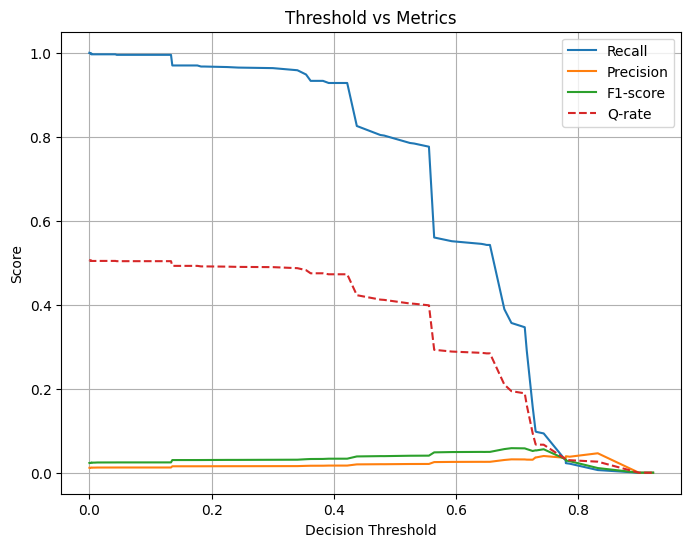

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------------------
# 1️⃣ 데이터 로드 및 분리
# ---------------------------------------------------------
X_lm = df[['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)', 'Target_Mean']]
y = df['JDGMNT_WORD_NAME_encoded']  # 예측할 타깃

cat_cols = ['INSPCT_PURPS_NAME', '1차 식품 분류 (세부)']
num_cols = ['Target_Mean']

# ---------------------------------------------------------
# 2️⃣ 학습/테스트 데이터 분리 (split 먼저)
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_lm, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------------------------------------
# 3️⃣ 인코딩 및 스케일링
# ---------------------------------------------------------
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

# Train 인코딩
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_train_num = scaler.fit_transform(X_train[num_cols])

# Test 인코딩 (transform만)
X_test_cat = encoder.transform(X_test[cat_cols])
X_test_num = scaler.transform(X_test[num_cols])

# 병합
X_train_final = np.hstack([X_train_cat, X_train_num])
X_test_final = np.hstack([X_test_cat, X_test_num])

# ---------------------------------------------------------
# 4️⃣ SMOTE (Train에만 적용)
# ---------------------------------------------------------
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train)

print(f"Before SMOTE: {np.bincount(y_train)}")
print(f"After SMOTE: {np.bincount(y_train_res)}")

# ---------------------------------------------------------
# 5️⃣ Hybrid 모델 구성 (MLP + Dropout + BN)
# ---------------------------------------------------------
input_dim = X_train_res.shape[1]
inputs = Input(shape=(input_dim,))
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# ---------------------------------------------------------
# 6️⃣ Compile (Positive Recall 최적화 목적)
# ---------------------------------------------------------
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['Precision', 'Recall', 'AUC'])

# ---------------------------------------------------------
# 7️⃣ EarlyStopping
# ---------------------------------------------------------
early_stop = EarlyStopping(monitor='val_recall',
                           patience=5,
                           restore_best_weights=True,
                           mode='max')

# ---------------------------------------------------------
# 8️⃣ Train
# ---------------------------------------------------------
history = model.fit(X_train_res, y_train_res,
                    validation_data=(X_test_final, y_test),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)

# ---------------------------------------------------------
# 9️⃣ 평가
# ---------------------------------------------------------
y_pred_prob = model.predict(X_test_final)
threshold = 0.5
y_pred = (y_pred_prob > threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ---------------------------------------------------------
# 🔟 임계값별 Precision, Recall, F1, Q-rate 시각화
# ---------------------------------------------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
q_rate = (recalls + precisions) / 2

plt.figure(figsize=(8,6))
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, f1_scores[:-1], label='F1-score')
plt.plot(thresholds, q_rate[:-1], label='Q-rate', linestyle='--')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
df.loc[:, 'tmprt_150_59':]

,tmprt_150_59,INSPCT_PURPS_NAME,1차 식품 분류 (세부),결과,결과값,JDGMNT_WORD_NAME_encoded,Target_Mean
0,12.1,자가품질위탁검사,"과자류, 빵류 또는 떡류",불검출,0,0,0.007676
1,12.1,자가품질위탁검사,"과자류, 빵류 또는 떡류",불검출,0,0,0.007676
2,12.7,자가품질위탁검사,"과자류, 빵류 또는 떡류",불검출,0,0,0.007676
3,12.5,자가품질위탁검사,건강기능식품(제품),불검출,0,0,0.003497
4,12.5,자가품질위탁검사,건강기능식품(제품),불검출,0,0,0.003497
...,...,...,...,...,...,...,...
337243,0.0,압·몰수품검사,기타식품류,불검출,0,0,0.087719
337244,0.0,압·몰수품검사,기타식품류,불검출,0,0,0.087719
337245,0.0,압·몰수품검사,기타식품류,불검출,0,0,0.087719
337246,15.7,압·몰수품검사,기타식품류,불검출,0,0,0.087719


### SMOTE Data Leakage
| 구분                   | 설명                                | 의미                                   |
| -------------------- | --------------------------------- | ------------------------------------ |
| **Leakage 모델**       | SMOTE가 test 정보까지 반영               | Precision, Recall, F1이 **비정상적으로 높음** |
| **Safe 모델**          | Train에만 SMOTE 적용                  | 성능이 더 현실적이며, 실제 unseen data 대응 가능    |
| **Confusion Matrix** | Leakage 모델은 False Negative가 거의 없음 | 실제로는 과적합                             |
| **AUC 비교**           | Leakage 모델이 과도하게 1.0 근처           | Data Leakage 징후                      |


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings(action='ignore')

# ---------------------------------------------------------
# 2️⃣ 모델 생성 함수
# ---------------------------------------------------------
def build_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['Precision', 'Recall', 'AUC'])
    return model


# ---------------------------------------------------------
# 3️⃣ Case 1: Data Leakage 발생 (SMOTE 후 split)
# ---------------------------------------------------------
encoder.fit(X_lm[cat_cols])
scaler.fit(X_lm[num_cols])

X_cat = encoder.transform(X_lm[cat_cols])
X_num = scaler.transform(X_lm[num_cols])
X_combined = np.hstack([X_cat, X_num])

# ❌ 잘못된 순서: 전체 데이터에 SMOTE 적용
smote = SMOTE(random_state=42, k_neighbors=3)
X_leak, y_leak = smote.fit_resample(X_combined, y)

X_train_leak, X_test_leak, y_train_leak, y_test_leak = train_test_split(
    X_leak, y_leak, test_size=0.2, random_state=42, stratify=y_leak
)

model_leak = build_model(X_train_leak.shape[1])
early_stop = EarlyStopping(monitor='val_recall', patience=10, restore_best_weights=True, mode='max')
model_leak.fit(X_train_leak, y_train_leak, validation_data=(X_test_leak, y_test_leak),
               epochs=100, batch_size=64, callbacks=[early_stop], verbose=0)

y_pred_leak = (model_leak.predict(X_test_leak) > 0.5).astype(int)
report_leak = classification_report(y_test_leak, y_pred_leak, output_dict=True)
auc_leak = roc_auc_score(y_test_leak, y_pred_leak)


# ---------------------------------------------------------
# 4️⃣ Case 2: 올바른 방식 (SMOTE 후 split)
# ---------------------------------------------------------
# Train/Test split 먼저
X_train, X_test, y_train, y_test = train_test_split(X_lm, y, test_size=0.2, random_state=42, stratify=y)

X_train_cat = encoder.transform(X_train[cat_cols])
X_train_num = scaler.transform(X_train[num_cols])
X_test_cat = encoder.transform(X_test[cat_cols])
X_test_num = scaler.transform(X_test[num_cols])

X_train_final = np.hstack([X_train_cat, X_train_num])
X_test_final = np.hstack([X_test_cat, X_test_num])

# ✅ 올바른 순서: train에만 SMOTE 적용
X_train_res, y_train_res = smote.fit_resample(X_train_final, y_train)

model_safe = build_model(X_train_res.shape[1])
model_safe.fit(X_train_res, y_train_res, validation_data=(X_test_final, y_test),
               epochs=100, batch_size=64, callbacks=[early_stop], verbose=0)

y_pred_safe = (model_safe.predict(X_test_final) > 0.5).astype(int)
report_safe = classification_report(y_test, y_pred_safe, output_dict=True)
auc_safe = roc_auc_score(y_test, y_pred_safe)


# ---------------------------------------------------------
# 5️⃣ 비교 시각화
# ---------------------------------------------------------
results = pd.DataFrame({
    "Precision": [report_leak['1']['precision'], report_safe['1']['precision']],
    "Recall": [report_leak['1']['recall'], report_safe['1']['recall']],
    "F1-score": [report_leak['1']['f1-score'], report_safe['1']['f1-score']],
    "AUC": [auc_leak, auc_safe]
}, index=["SMOTE Before Split (Leak)", "SMOTE After Split (Safe)"])

plt.figure(figsize=(8,5))
sns.heatmap(results, annot=True, fmt=".3f", cmap="Blues")
plt.title("Performance Comparison: Data Leakage vs Safe SMOTE")
plt.show()


# ---------------------------------------------------------
# 6️⃣ Confusion Matrix 비교
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.heatmap(confusion_matrix(y_test_leak, y_pred_leak), annot=True, fmt="d", cmap="Greens", ax=axes[0])
axes[0].set_title("❌ Leakage SMOTE")

sns.heatmap(confusion_matrix(y_test, y_pred_safe), annot=True, fmt="d", cmap="Oranges", ax=axes[1])
axes[1].set_title("✅ Safe SMOTE")

plt.tight_layout()
plt.show()

# 두 모델의 학습 곡선(Epoch vs Recall) 비교 그래프도 추가해서
#“Leakage로 인한 과적합”을 직관적으로 보여준다.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_recall` which is not available. Available metrics are: AUC,Precision,Recall,loss,val_AUC,val_Precision,val_Recall,val_loss
  current = self.get_monitor_value(logs)
